In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import date
from datetime import datetime

from scipy.stats import boxcox

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

# Functions

### list_unique() defnition

In [8]:
def list_unique(col):
    list_origin = list(col)
    
    for idx, items in enumerate(list_origin):
        if ";" in items:
            elems=items.split(";")
            list_origin[idx] = elems.pop(0)
            for elem in elems:
                list_origin.append(elem)
                
    res = list(set(list_origin))
    
    return res

### mean_owners() defnition

In [9]:
def mean_owners(str):
    lst = str.split("-")
    return (int(lst[0])+int(lst[1]))/2

### outliers_lim() definition

In [10]:
def outliers_lim(column, dataset):
    
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1

    Outlierbottom = Q1 - IQR*1.5

    Outliertop = Q3 + IQR*1.5
    
    print(column+" outliers limits : below "+str(Outlierbottom)+" and above "+str(Outliertop))
    print("\nMin, Max values : "+str(dataset[column].loc[(dataset[column]<Outlierbottom) | (dataset[column]>Outliertop)].min())+" "+str(dataset[column].loc[(dataset[column]<Outlierbottom) | (dataset[column]>Outliertop)].max()))
    print("\nNb of outliers : "+str(dataset[column].loc[(dataset[column]<Outlierbottom) | (dataset[column]>Outliertop)].count()))
    
    return Outlierbottom, Outliertop

# Import and first look at the data

In [11]:
path_data = r"C:\Users\jeanb\Desktop\Cours\Cours Ironhack\Projets\Projet_week_7"
data = pd.read_csv(path_data+"/steam.csv")

In [12]:
data.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [13]:
data.shape

(27075, 18)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
appid               27075 non-null int64
name                27075 non-null object
release_date        27075 non-null object
english             27075 non-null int64
developer           27075 non-null object
publisher           27075 non-null object
platforms           27075 non-null object
required_age        27075 non-null int64
categories          27075 non-null object
genres              27075 non-null object
steamspy_tags       27075 non-null object
achievements        27075 non-null int64
positive_ratings    27075 non-null int64
negative_ratings    27075 non-null int64
average_playtime    27075 non-null int64
median_playtime     27075 non-null int64
owners              27075 non-null object
price               27075 non-null float64
dtypes: float64(1), int64(8), object(9)
memory usage: 3.7+ MB


# Cleaning the dataset

- Calculating age of the games (release_date)
- Create dummies for platforms
- Create dummies for required_age
- Handling categories column
- Create dummies for genres
- Create positive/negative reviews column (test if nb positive ratings is superior or inferior to nb negative ratings) + total_ratings column
- Create estimate owners column (mean between the 2 values of owners)
- Drop appid, (name ?), release_date, developer, publisher, platforms; required age, genres, steamspy_tags, owners

Checking columns for nan

In [15]:
data.isna().sum()

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

### Calculating age of the games (release_date)

In [16]:
def calculateAge(birthDate):
    birthDate = datetime.strptime(birthDate, '%Y-%m-%d').date()
    today = date.today() 
    age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day)) 
  
    return age

In [17]:
data["game_age"] = data.apply(lambda row : calculateAge(row["release_date"]), axis=1)

### Creating dummies for platforms

Formating platforms column 

In [18]:
data["platforms"] = data.apply(lambda row : row["platforms"].split(";") , axis=1)

Creating dummies for platforms

In [19]:
mlb = MultiLabelBinarizer()
platforms_dummies = pd.DataFrame(mlb.fit_transform(data.platforms),
                          columns=mlb.classes_,
                          index=data.index).add_prefix('platforms_')

In [20]:
platforms_dummies

,platforms_linux,platforms_mac,platforms_windows
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
27070,0,0,1
27071,0,0,1
27072,0,0,1
27073,0,1,1


In [21]:
data=data.join(platforms_dummies)

In [22]:
data.shape

(27075, 22)

### Create dummies for required_age

In [23]:
data = pd.get_dummies(data=data, columns=["required_age"], prefix="req_age", prefix_sep='_', drop_first=True)

In [24]:
data.head()

,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,...,price,game_age,platforms_linux,platforms_mac,platforms_windows,req_age_3,req_age_7,req_age_12,req_age_16,req_age_18
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,"[windows, mac, linux]",Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,...,7.19,19,1,1,1,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,"[windows, mac, linux]",Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,...,3.99,21,1,1,1,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,"[windows, mac, linux]",Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,...,3.99,17,1,1,1,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,"[windows, mac, linux]",Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,...,3.99,18,1,1,1,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,"[windows, mac, linux]",Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,...,3.99,20,1,1,1,0,0,0,0,0


In [25]:
data.shape

(27075, 26)

### Creating dummies for categories

Getting unique values for categories column

In [26]:
unique_cat = list_unique(data.categories)

In [30]:
unique_cat.sort()

Creating categories dictionnary to map lists of categories column

In [31]:
values = ["Other","Co-op","Other","Cross-Platform Multiplayer","Controller","In-App Purchases","Other","Other","Local Co-op","Local Multi-Player","Online Multi-Player","Mods","Mods","Multi-player","Online Co-op'","Online Multi-Player",
"Controller","Shared/Split Screen","Single-player","Other","Other","Other","Other","Other","Other","Mods","VR","VR","Other"]

In [33]:
dict_cat = dict(zip(unique_cat, values))

Formating categories column 

In [36]:
data["categories"] = data.apply(lambda row : list(set(map(dict_cat.get,row["categories"].split(";")))) , axis=1)

In [37]:
mlb = MultiLabelBinarizer()
cat_dummies = pd.DataFrame(mlb.fit_transform(data.categories),
                          columns=mlb.classes_,
                          index=data.index).add_prefix('categ_')

In [38]:
cat_dummies

,categ_Co-op,categ_Controller,categ_Cross-Platform Multiplayer,categ_In-App Purchases,categ_Local Co-op,categ_Local Multi-Player,categ_Mods,categ_Multi-player,categ_Online Co-op',categ_Online Multi-Player,categ_Other,categ_Shared/Split Screen,categ_Single-player,categ_VR
0,0,0,0,0,0,1,0,1,0,1,1,0,0,0
1,0,0,0,0,0,1,0,1,0,1,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,1,0,1,0,1,1,0,0,0
4,0,0,0,0,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,1,0,1,0
27071,0,0,0,0,0,0,0,0,0,0,0,0,1,0
27072,1,1,0,0,0,0,0,1,0,0,1,1,1,0
27073,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [39]:
data=data.join(cat_dummies)

In [40]:
data.shape

(27075, 40)

### Creating dummies genres

Getting unique values for genres column

In [41]:
unique_genres = list_unique(data.genres)

In [42]:
unique_genres.sort()

In [43]:
len(unique_genres)

29

In [44]:
values = ["Other","Action","Adventure","Other","Other","Casual","Other","Other","Other","Other","Free to Play","Other","Other","Indie","Massively Multiplayer","Other","Other","RPG",
         "Racing","Other","Simulation","Other","Sports","Strategy","Other","Other","Other","Other","Other"]

In [45]:
dict_gen = dict(zip(unique_genres, values))

In [46]:
dict_gen

{'Accounting': 'Other',
 'Action': 'Action',
 'Adventure': 'Adventure',
 'Animation & Modeling': 'Other',
 'Audio Production': 'Other',
 'Casual': 'Casual',
 'Design & Illustration': 'Other',
 'Documentary': 'Other',
 'Early Access': 'Other',
 'Education': 'Other',
 'Free to Play': 'Free to Play',
 'Game Development': 'Other',
 'Gore': 'Other',
 'Indie': 'Indie',
 'Massively Multiplayer': 'Massively Multiplayer',
 'Nudity': 'Other',
 'Photo Editing': 'Other',
 'RPG': 'RPG',
 'Racing': 'Racing',
 'Sexual Content': 'Other',
 'Simulation': 'Simulation',
 'Software Training': 'Other',
 'Sports': 'Sports',
 'Strategy': 'Strategy',
 'Tutorial': 'Other',
 'Utilities': 'Other',
 'Video Production': 'Other',
 'Violent': 'Other',
 'Web Publishing': 'Other'}

Formating genres column

In [47]:
data["genres"] = data.apply(lambda row : list(set(map(dict_gen.get,row["genres"].split(";")))) , axis=1)

In [48]:
gen_dummies = pd.DataFrame(mlb.fit_transform(data.genres),
                          columns=mlb.classes_,
                          index=data.index).add_prefix('gen_')

In [49]:
gen_dummies

,gen_Action,gen_Adventure,gen_Casual,gen_Free to Play,gen_Indie,gen_Massively Multiplayer,gen_Other,gen_RPG,gen_Racing,gen_Simulation,gen_Sports,gen_Strategy
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,1,1,0,1,0,0,0,0,0,0,0
27071,1,1,0,0,1,0,0,0,0,0,0,0
27072,1,0,1,0,1,0,0,0,0,0,0,0
27073,0,1,1,0,1,0,0,0,0,0,0,0


In [50]:
data=data.join(gen_dummies)

In [51]:
data.shape

(27075, 52)

### Creating reviews column (1 if more positive ratings, 0 if negative ratings) + total_ratings column

In [52]:
data["reviews"] = data.apply(lambda row : 1 if row.positive_ratings > row.negative_ratings else 0, axis=1)

In [53]:
data["tot_ratings"] = data.apply(lambda row : row.positive_ratings+row.negative_ratings, axis=1)

In [54]:
data.shape

(27075, 54)

In [55]:
data[data.tot_ratings >= 100]

,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,...,gen_Indie,gen_Massively Multiplayer,gen_Other,gen_RPG,gen_Racing,gen_Simulation,gen_Sports,gen_Strategy,reviews,tot_ratings
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,"[windows, mac, linux]","[Other, Local Multi-Player, Multi-player, Onli...",[Action],Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,1,127873
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,"[windows, mac, linux]","[Other, Local Multi-Player, Multi-player, Onli...",[Action],Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,1,3951
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,"[windows, mac, linux]","[Multi-player, Other]",[Action],FPS;World War II;Multiplayer,...,0,0,0,0,0,0,0,0,1,3814
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,"[windows, mac, linux]","[Other, Local Multi-Player, Multi-player, Onli...",[Action],Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,1,1540
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,"[windows, mac, linux]","[Single-player, Multi-player, Other]",[Action],FPS;Action;Sci-fi,...,0,0,0,0,0,0,0,0,1,5538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26899,1046030,ISLANDERS,2019-04-04,1,GrizzlyGames,GrizzlyGames,[windows],"[Single-player, Other]","[Strategy, Indie, Casual]",Strategy;Indie;City Builder,...,1,0,0,0,0,0,0,1,1,1567
26951,1049800,BLOCKADE Classic,2019-04-01,1,Novalink,Novalink,[windows],"[In-App Purchases, Online Multi-Player]","[Other, Free to Play, Indie, Action, Massively...",Early Access;Free to Play;Action,...,1,1,1,0,0,0,0,0,1,397
26973,1051310,Paper Dolls: Original / 纸人：第一章,2019-04-19,1,"Beijing Litchi Culture Media Co., Ltd.",Gamera Game,[windows],"[Single-player, Controller, Other]","[Indie, Action, Adventure]",Adventure;Action;Indie,...,1,0,0,0,0,0,0,0,1,324
26981,1052070,Burning Daylight,2019-04-19,1,Burning Daylight Team,Burning Daylight Team,[windows],[Single-player],"[Indie, Adventure, Free to Play]",Free to Play;Adventure;Indie,...,1,0,0,0,0,0,0,0,1,767


### Creating estimate owners column

In [56]:
data["estim_owners"] = data.apply(lambda row : mean_owners(row["owners"]), axis=1)

In [57]:
data.head()

,appid,name,release_date,english,developer,publisher,platforms,categories,genres,steamspy_tags,...,gen_Massively Multiplayer,gen_Other,gen_RPG,gen_Racing,gen_Simulation,gen_Sports,gen_Strategy,reviews,tot_ratings,estim_owners
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,"[windows, mac, linux]","[Other, Local Multi-Player, Multi-player, Onli...",[Action],Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,1,127873,15000000.0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,"[windows, mac, linux]","[Other, Local Multi-Player, Multi-player, Onli...",[Action],Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,1,3951,7500000.0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,"[windows, mac, linux]","[Multi-player, Other]",[Action],FPS;World War II;Multiplayer,...,0,0,0,0,0,0,0,1,3814,7500000.0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,"[windows, mac, linux]","[Other, Local Multi-Player, Multi-player, Onli...",[Action],Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,1,1540,7500000.0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,"[windows, mac, linux]","[Single-player, Multi-player, Other]",[Action],FPS;Action;Sci-fi,...,0,0,0,0,0,0,0,1,5538,7500000.0


In [58]:
data.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'categories', 'genres', 'steamspy_tags', 'achievements',
       'positive_ratings', 'negative_ratings', 'average_playtime',
       'median_playtime', 'owners', 'price', 'game_age', 'platforms_linux',
       'platforms_mac', 'platforms_windows', 'req_age_3', 'req_age_7',
       'req_age_12', 'req_age_16', 'req_age_18', 'categ_Co-op',
       'categ_Controller', 'categ_Cross-Platform Multiplayer',
       'categ_In-App Purchases', 'categ_Local Co-op',
       'categ_Local Multi-Player', 'categ_Mods', 'categ_Multi-player',
       'categ_Online Co-op'', 'categ_Online Multi-Player', 'categ_Other',
       'categ_Shared/Split Screen', 'categ_Single-player', 'categ_VR',
       'gen_Action', 'gen_Adventure', 'gen_Casual', 'gen_Free to Play',
       'gen_Indie', 'gen_Massively Multiplayer', 'gen_Other', 'gen_RPG',
       'gen_Racing', 'gen_Simulation', 'gen_Sports', 'gen_Strategy', 'reviews',
       'to

In [59]:
data.english.value_counts()

1    26564
0      511
Name: english, dtype: int64

In [60]:
data.reviews.value_counts()

1    21923
0     5152
Name: reviews, dtype: int64

### Dropping several columns

In [61]:
data = data.drop(["appid","release_date","developer","publisher","platforms","categories","genres","steamspy_tags","owners"], axis=1)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 46 columns):
name                                27075 non-null object
english                             27075 non-null int64
achievements                        27075 non-null int64
positive_ratings                    27075 non-null int64
negative_ratings                    27075 non-null int64
average_playtime                    27075 non-null int64
median_playtime                     27075 non-null int64
price                               27075 non-null float64
game_age                            27075 non-null int64
platforms_linux                     27075 non-null int32
platforms_mac                       27075 non-null int32
platforms_windows                   27075 non-null int32
req_age_3                           27075 non-null uint8
req_age_7                           27075 non-null uint8
req_age_12                          27075 non-null uint8
req_age_16                       

In [63]:
data.columns

Index(['name', 'english', 'achievements', 'positive_ratings',
       'negative_ratings', 'average_playtime', 'median_playtime', 'price',
       'game_age', 'platforms_linux', 'platforms_mac', 'platforms_windows',
       'req_age_3', 'req_age_7', 'req_age_12', 'req_age_16', 'req_age_18',
       'categ_Co-op', 'categ_Controller', 'categ_Cross-Platform Multiplayer',
       'categ_In-App Purchases', 'categ_Local Co-op',
       'categ_Local Multi-Player', 'categ_Mods', 'categ_Multi-player',
       'categ_Online Co-op'', 'categ_Online Multi-Player', 'categ_Other',
       'categ_Shared/Split Screen', 'categ_Single-player', 'categ_VR',
       'gen_Action', 'gen_Adventure', 'gen_Casual', 'gen_Free to Play',
       'gen_Indie', 'gen_Massively Multiplayer', 'gen_Other', 'gen_RPG',
       'gen_Racing', 'gen_Simulation', 'gen_Sports', 'gen_Strategy', 'reviews',
       'tot_ratings', 'estim_owners'],
      dtype='object')

### Descriptive Stats

In [64]:
def stat_col(col):
    
    return data[col][(data[col] == 1) & (data.reviews == 1)].count() / data[col][(data[col] == 1)].count()
    

In [65]:
gen_names = list(data.columns[31:43])

In [66]:
gen_names

['gen_Action',
 'gen_Adventure',
 'gen_Casual',
 'gen_Free to Play',
 'gen_Indie',
 'gen_Massively Multiplayer',
 'gen_Other',
 'gen_RPG',
 'gen_Racing',
 'gen_Simulation',
 'gen_Sports',
 'gen_Strategy']

In [67]:
pos_rev = []
for i in gen_names:
    pos_rev.append(stat_col(i))

In [68]:
pos_rev

[0.8013105939679073,
 0.8123006379585327,
 0.7907933398628796,
 0.8485915492957746,
 0.8145306626847227,
 0.7275242047026279,
 0.7718787878787878,
 0.8332173509626537,
 0.7548828125,
 0.7474008471313054,
 0.7579425113464447,
 0.8019820850009529]

In [69]:
df_genre = pd.DataFrame({"pos_rev":pos_rev},gen_names)

In [70]:
df_genre["neg_rev"] = 1-df_genre.pos_rev

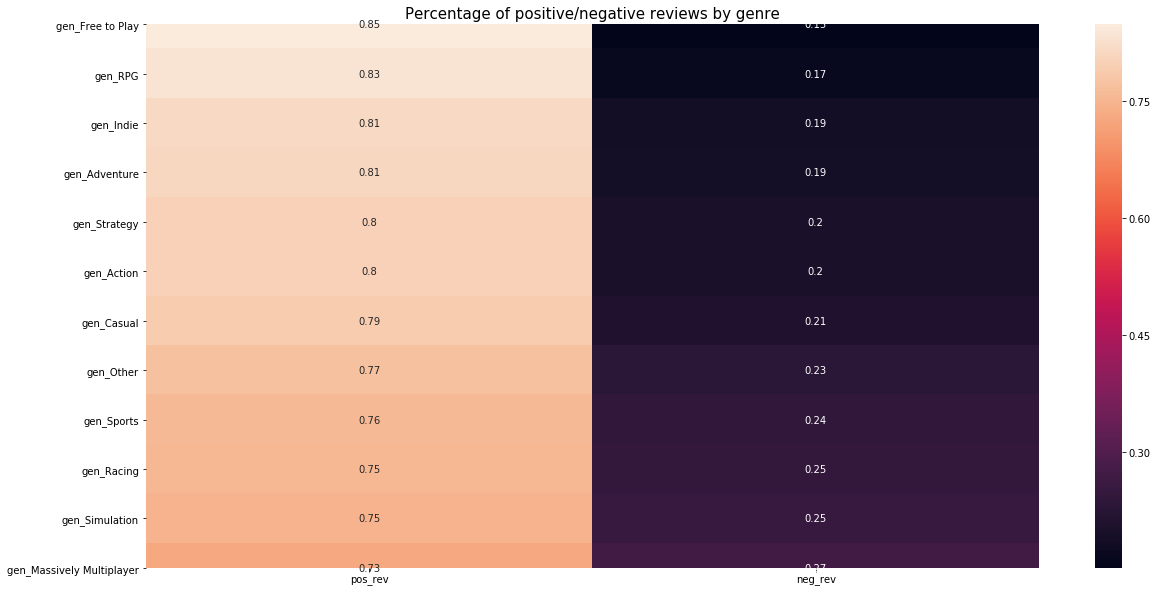

In [71]:
plt.figure(figsize=(20,10))
plt.title("Percentage of positive/negative reviews by genre", size=15)
sns.heatmap(df_genre.sort_values(by="pos_rev", ascending=False), annot = True)

In [72]:
cat_names = list(data.columns[17:31])

In [73]:
pos_rev2 = []
for i in cat_names:
    pos_rev2.append(stat_col(i))

In [74]:
pos_rev2

[0.862870424171993,
 0.8725035303611055,
 0.8649398704902868,
 0.7913043478260869,
 0.8961284230406044,
 0.871826625386997,
 0.9208472686733556,
 0.8361852038248616,
 0.8487394957983193,
 0.8297389330306469,
 0.8555555555555555,
 0.8847583643122676,
 0.811005530025703,
 0.8503937007874016]

In [75]:
df_cat = pd.DataFrame({"pos_rev":pos_rev2},cat_names)

In [78]:
df_cat["neg_rev"] = 1-df_cat.pos_rev

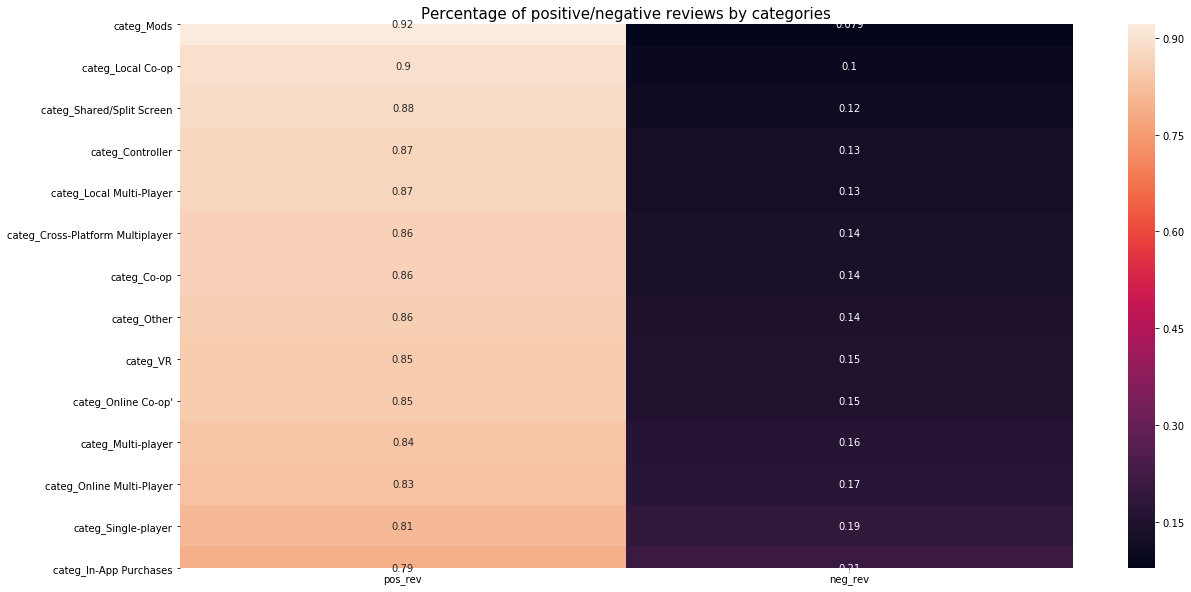

In [80]:
plt.figure(figsize=(20,10))
plt.title("Percentage of positive/negative reviews by categories", size=15)
sns.heatmap(df_cat.sort_values(by="pos_rev", ascending=False), annot = True)

### Checking normality of numeric columns

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E3D7D2248>],
      dtype=object)

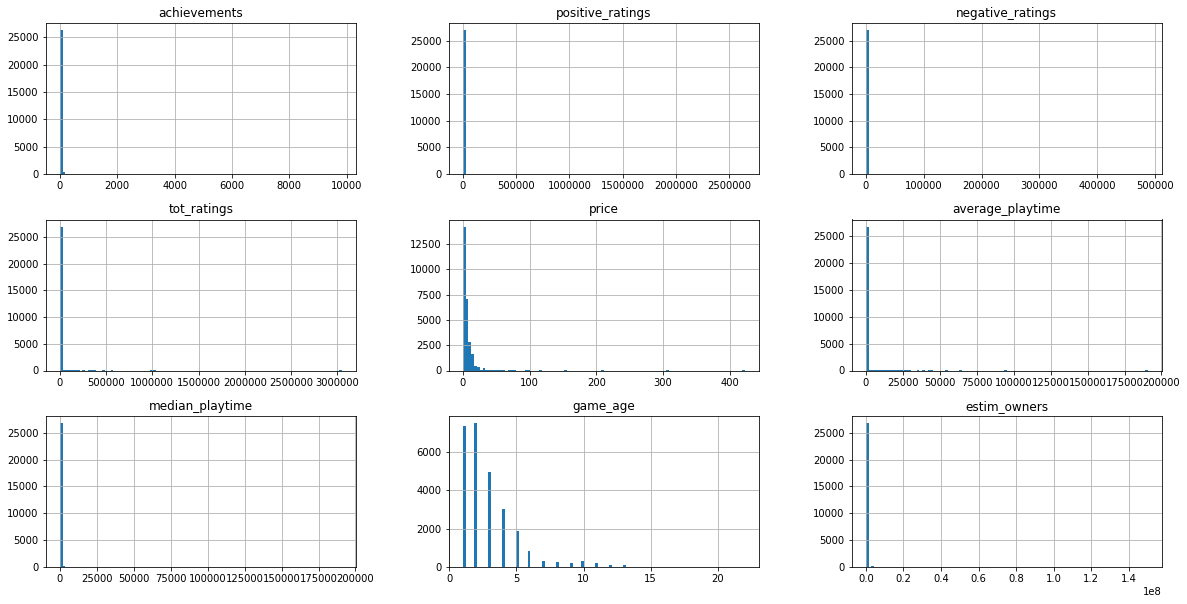

In [81]:
fig, axes = plt.subplots(3, 3, figsize =(20,10))

data.hist('achievements', bins=100, ax=axes[0][0])
data.hist('positive_ratings', bins=100, ax=axes[0][1])
data.hist('negative_ratings', bins=100, ax=axes[0][2])

data.hist('tot_ratings', bins=100, ax=axes[1][0])
data.hist('price', bins=100, ax=axes[1][1])
data.hist('average_playtime', bins=100, ax=axes[1][2])

data.hist('median_playtime', bins=100, ax=axes[2][0])
data.hist('game_age', bins=100, ax=axes[2][1])
data.hist('estim_owners', bins=100, ax=axes[2][2])

Text(0, 0.5, 'Occurence of nb achievements')

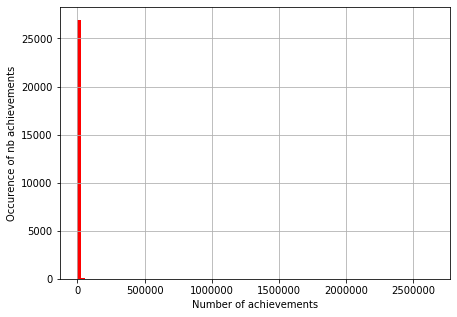

In [82]:
data.positive_ratings.hist(bins=100, figsize=(7,5), color = "red")
plt.xlabel('Number of achievements')
plt.ylabel('Occurence of nb achievements')

### Converting numerical columns to normal distribution

Selecting numerical columns

In [83]:
data_numerical = data[["name","achievements","positive_ratings","negative_ratings","tot_ratings","price","average_playtime","median_playtime","game_age","estim_owners"]]

In [84]:
data_numerical.describe()

,achievements,positive_ratings,negative_ratings,tot_ratings,price,average_playtime,median_playtime,game_age,estim_owners
count,27075.000000,2.707500e+04,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000,2.707500e+04
mean,45.248864,1.000559e+03,211.027147,1.211586e+03,6.078193,149.804949,146.05603,2.875420,1.340905e+05
std,352.670281,1.898872e+04,4284.938531,2.242909e+04,7.874922,1827.038141,2353.88008,2.130405,1.328089e+06
min,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000,0.00000,1.000000,1.000000e+04
25%,0.000000,6.000000e+00,2.000000,1.000000e+01,1.690000,0.000000,0.00000,1.000000,1.000000e+04
50%,7.000000,2.400000e+01,9.000000,3.600000e+01,3.990000,0.000000,0.00000,2.000000,1.000000e+04
75%,23.000000,1.260000e+02,42.000000,1.760000e+02,7.190000,0.000000,0.00000,4.000000,3.500000e+04
max,9821.000000,2.644404e+06,487076.000000,3.046717e+06,421.990000,190625.000000,190625.00000,22.000000,1.500000e+08


Creating log columns

In [85]:
data_numerical.achievements = data_numerical.achievements+1
data_numerical.positive_ratings = data_numerical.positive_ratings+1
data_numerical.negative_ratings = data_numerical.negative_ratings+1
data_numerical.price = data_numerical.price+1
data_numerical.average_playtime = data_numerical.average_playtime+1
data_numerical.median_playtime = data_numerical.median_playtime+1

C:\Users\jeanb\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [86]:
data_numerical["achievements_log"] = boxcox(data_numerical.achievements, 0)
data_numerical["positive_ratings_log"] = boxcox(data_numerical.positive_ratings, 0)
data_numerical["negative_ratings_log"] = boxcox(data_numerical.negative_ratings, 0)
data_numerical["tot_ratings_log"] = boxcox(data_numerical.tot_ratings, 0)
data_numerical["price_log"] = boxcox(data_numerical.price, 0)
data_numerical["average_playtime_log"] = boxcox(data_numerical.average_playtime, 0)
data_numerical["median_playtime_log"] = boxcox(data_numerical.median_playtime, 0)
data_numerical["game_age_log"] = boxcox(data_numerical.game_age, 0)
data_numerical["estim_owners_log"] = boxcox(data_numerical.estim_owners, 0)

C:\Users\jeanb\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jeanb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jeanb\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Plotting the histograms with log columns

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E3FEDB488>],
      dtype=object)

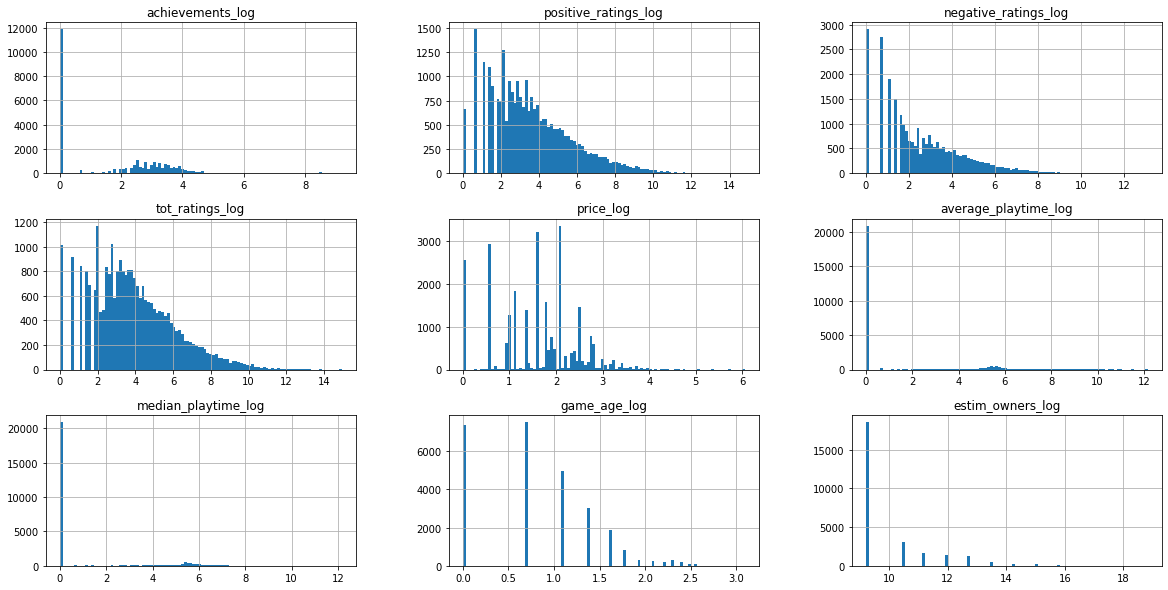

In [87]:
fig, axes = plt.subplots(3, 3, figsize =(20,10))

data_numerical.hist('achievements_log', bins=100, ax=axes[0][0])
data_numerical.hist('positive_ratings_log', bins=100, ax=axes[0][1])
data_numerical.hist('negative_ratings_log', bins=100, ax=axes[0][2])

data_numerical.hist('tot_ratings_log', bins=100, ax=axes[1][0])
data_numerical.hist('price_log', bins=100, ax=axes[1][1])
data_numerical.hist('average_playtime_log', bins=100, ax=axes[1][2])

data_numerical.hist('median_playtime_log', bins=100, ax=axes[2][0])
data_numerical.hist('game_age_log', bins=100, ax=axes[2][1])
data_numerical.hist('estim_owners_log', bins=100, ax=axes[2][2])

### Checking outliers for numeric columns

Orginal columns

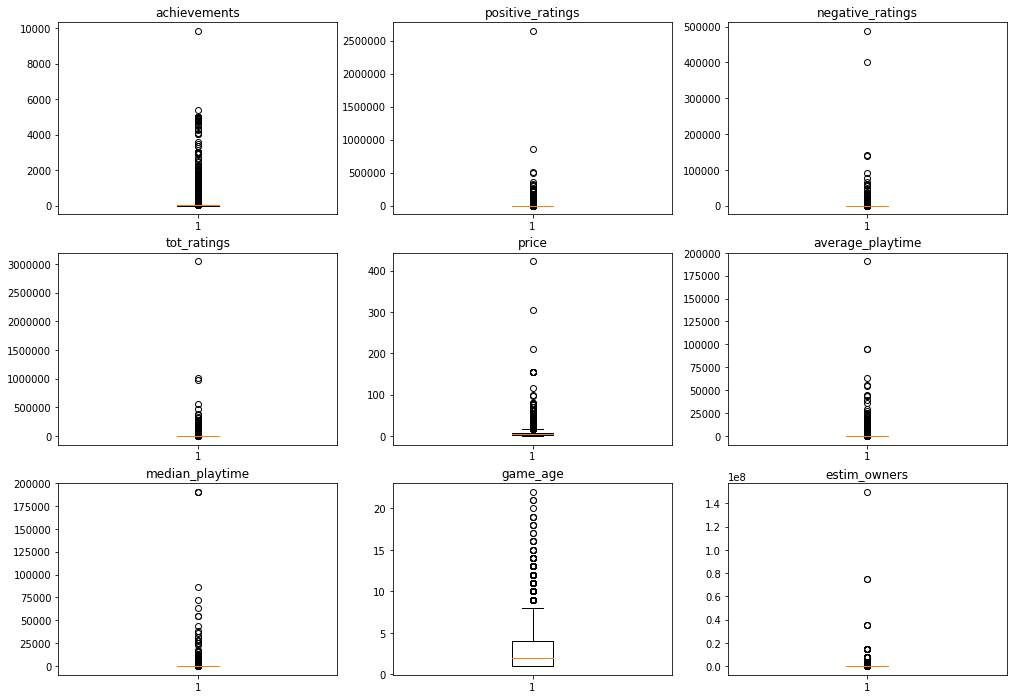

In [90]:
fig, axs = plt.subplots(3,3, figsize = (17,12))

axs[0][0].boxplot(data.achievements)
axs[0][0].set_title("achievements")

axs[0][1].boxplot(data.positive_ratings)
axs[0][1].set_title("positive_ratings")

axs[0][2].boxplot(data.negative_ratings)
axs[0][2].set_title("negative_ratings")

axs[1][0].boxplot(data.tot_ratings)
axs[1][0].set_title("tot_ratings")

axs[1][1].boxplot(data.price)
axs[1][1].set_title("price")

axs[1][2].boxplot(data.average_playtime)
axs[1][2].set_title("average_playtime")

axs[2][0].boxplot(data.median_playtime)
axs[2][0].set_title("median_playtime")

axs[2][1].boxplot(data.game_age)
axs[2][1].set_title("game_age")

axs[2][2].boxplot(data.estim_owners)
axs[2][2].set_title("estim_owners")


plt.show()

Loged columns

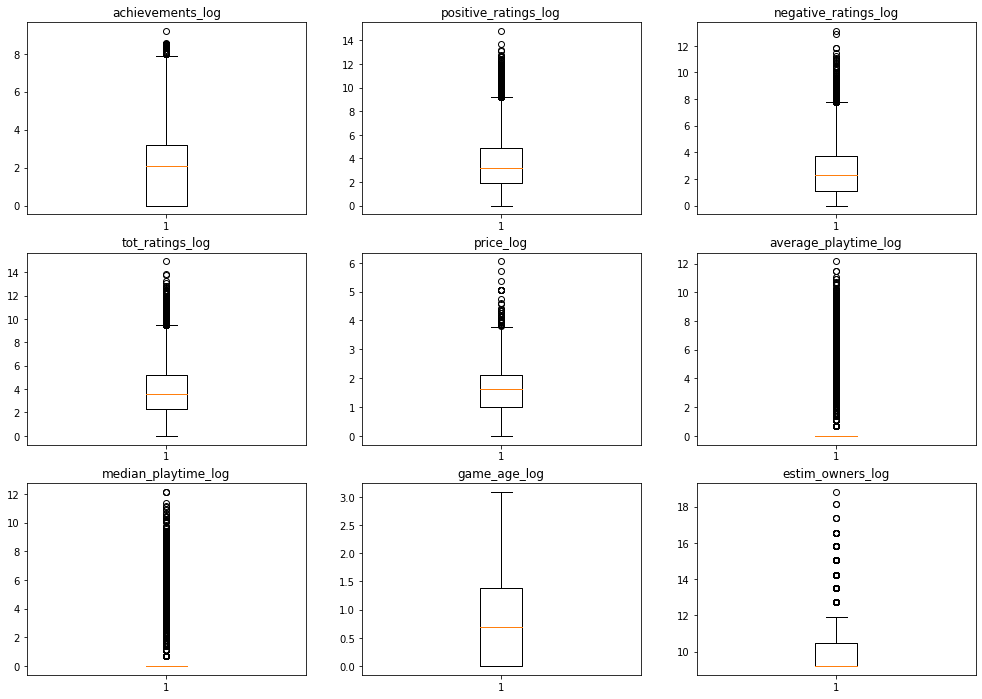

In [91]:
fig, axs = plt.subplots(3,3, figsize = (17,12))

axs[0][0].boxplot(data_numerical.achievements_log)
axs[0][0].set_title("achievements_log")

axs[0][1].boxplot(data_numerical.positive_ratings_log)
axs[0][1].set_title("positive_ratings_log")

axs[0][2].boxplot(data_numerical.negative_ratings_log)
axs[0][2].set_title("negative_ratings_log")

axs[1][0].boxplot(data_numerical.tot_ratings_log)
axs[1][0].set_title("tot_ratings_log")

axs[1][1].boxplot(data_numerical.price_log)
axs[1][1].set_title("price_log")

axs[1][2].boxplot(data_numerical.average_playtime_log)
axs[1][2].set_title("average_playtime_log")

axs[2][0].boxplot(data_numerical.median_playtime_log)
axs[2][0].set_title("median_playtime_log")

axs[2][1].boxplot(data_numerical.game_age_log)
axs[2][1].set_title("game_age_log")

axs[2][2].boxplot(data_numerical.estim_owners_log)
axs[2][2].set_title("estim_owners_log")


plt.show()

In [92]:
data[data.achievements>6000] # LOGistICAL 12604
data[data.positive_ratings>1000000] # CS:GO 25
data[data.negative_ratings>200000] # CS:GO 25 / PUBG 12836
data[data.tot_ratings>1500000] # CS:GO 25
data[data.price>200] # Houdini Indie 10034 / GameMaker Studio 2 UWP 13062 / ADR-Labelling Game 21105
data[data.average_playtime>100000] # The Abbey of Crime Extensum 9201
data[data.median_playtime>100000] # The Banner Saga: Factions 1478 / The Secret of Tremendous Corporation 6014 / The Abbey of Crime Extensum 9201
data[data.estim_owners>15000000] # Team Fortress 2 19 / Dota 2 22 / CS:GO 25 / Warframe 1634 / Unturned 3362 / PUBG 12836

,name,english,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,game_age,platforms_linux,...,gen_Massively Multiplayer,gen_Other,gen_RPG,gen_Racing,gen_Simulation,gen_Sports,gen_Strategy,reviews,tot_ratings,estim_owners
19,Team Fortress 2,1,520,515879,34036,8495,623,0.00,12,1,...,0,0,0,0,0,0,0,1,549915,35000000.0
22,Dota 2,1,0,863507,142079,23944,801,0.00,6,1,...,0,0,0,0,0,0,1,1,1005586,150000000.0
25,Counter-Strike: Global Offensive,1,167,2644404,402313,22494,6502,0.00,7,1,...,0,0,0,0,0,0,0,1,3046717,75000000.0
1634,Warframe,1,187,226541,20268,5845,394,0.00,7,0,...,0,0,0,0,0,0,0,1,246809,35000000.0
3362,Unturned,1,46,292574,31482,3248,413,0.00,2,1,...,0,0,0,0,0,0,0,1,324056,35000000.0
12836,PLAYERUNKNOWN'S BATTLEGROUNDS,1,37,496184,487076,22938,12434,26.99,2,0,...,1,0,0,0,0,0,0,1,983260,75000000.0


In [93]:
ob_achievements, ot_achievements = outliers_lim("achievements_log", data_numerical)

achievements_log outliers limits : below -4.767080745521919 and above 7.945134575869865

Min, Max values : 7.9658927350845286 9.19238004659919

Nb of outliers : 135


In [94]:
ob_pos_rat, ot_pos_rat = outliers_lim("positive_ratings_log", data_numerical)

positive_ratings_log outliers limits : below -2.401505257049603 and above 9.191602492563508

Min, Max values : 9.191972714617998 14.787956645227853

Nb of outliers : 419


In [95]:
ob_neg_rat, ot_neg_rat = outliers_lim("negative_ratings_log", data_numerical)

negative_ratings_log outliers limits : below -2.8952694518700692 and above 7.755081856231742

Min, Max values : 7.757051142032013 13.096177500449475

Nb of outliers : 339


In [96]:
ob_tot_rat, ot_tot_rat = outliers_lim("tot_ratings_log", data_numerical)

tot_ratings_log outliers limits : below -1.9992632600721123 and above 9.47233234810431

Min, Max values : 9.47677327138879 14.929575175413502

Nb of outliers : 383


In [97]:
ob_price, ot_price = outliers_lim("price_log", data_numerical)

price_log outliers limits : below -0.6805178627630983 and above 3.7729729542418244

Min, Max values : 3.824284091120139 6.047348538104894

Nb of outliers : 111


In [98]:
ob_avg_playt, ot_avg_playt = outliers_lim("average_playtime_log", data_numerical)

average_playtime_log outliers limits : below 0.0 and above 0.0

Min, Max values : 0.6931471805599453 12.158068672231693

Nb of outliers : 6170


In [99]:
ob_med_playt, ot_med_playt = outliers_lim("median_playtime_log", data_numerical)

median_playtime_log outliers limits : below 0.0 and above 0.0

Min, Max values : 0.6931471805599453 12.158068672231693

Nb of outliers : 6170


In [100]:
ob_game_age, ot_game_age = outliers_lim("game_age_log", data_numerical)

game_age_log outliers limits : below -2.0794415416798357 and above 3.465735902799726

Min, Max values : nan nan

Nb of outliers : 0


In [101]:
ob_est_own, ot_est_own = outliers_lim("estim_owners_log", data_numerical)

estim_owners_log outliers limits : below 7.331195919233134 and above 12.3422477932146

Min, Max values : 12.765688433465597 18.82614585206053

Nb of outliers : 2339


### Creation of log columns to data

In [102]:
data.achievements = data.achievements+1
data.positive_ratings = data.positive_ratings+1
data.negative_ratings = data.negative_ratings+1
data.price = data.price+1
data.average_playtime = data.average_playtime+1
data.median_playtime = data.median_playtime+1

In [103]:
data["achievements_log"] = boxcox(data.achievements, 0)
data["positive_ratings_log"] = boxcox(data.positive_ratings, 0)
data["negative_ratings_log"] = boxcox(data.negative_ratings, 0)
data["tot_ratings_log"] = boxcox(data.tot_ratings, 0)
data["price_log"] = boxcox(data.price, 0)
data["average_playtime_log"] = boxcox(data.average_playtime, 0)
data["median_playtime_log"] = boxcox(data.median_playtime, 0)
data["game_age_log"] = boxcox(data.game_age, 0)
data["estim_owners_log"] = boxcox(data.estim_owners, 0)

In [104]:
data = data.drop(["achievements","positive_ratings","negative_ratings","tot_ratings","price","average_playtime","median_playtime","game_age","estim_owners"], axis=1)

In [105]:
data.columns

Index(['name', 'english', 'platforms_linux', 'platforms_mac',
       'platforms_windows', 'req_age_3', 'req_age_7', 'req_age_12',
       'req_age_16', 'req_age_18', 'categ_Co-op', 'categ_Controller',
       'categ_Cross-Platform Multiplayer', 'categ_In-App Purchases',
       'categ_Local Co-op', 'categ_Local Multi-Player', 'categ_Mods',
       'categ_Multi-player', 'categ_Online Co-op'',
       'categ_Online Multi-Player', 'categ_Other', 'categ_Shared/Split Screen',
       'categ_Single-player', 'categ_VR', 'gen_Action', 'gen_Adventure',
       'gen_Casual', 'gen_Free to Play', 'gen_Indie',
       'gen_Massively Multiplayer', 'gen_Other', 'gen_RPG', 'gen_Racing',
       'gen_Simulation', 'gen_Sports', 'gen_Strategy', 'reviews',
       'achievements_log', 'positive_ratings_log', 'negative_ratings_log',
       'tot_ratings_log', 'price_log', 'average_playtime_log',
       'median_playtime_log', 'game_age_log', 'estim_owners_log'],
      dtype='object')

### Creation of outliers columns

In [106]:
data["ach_outliers"] = data.apply(lambda row : 0 if ob_achievements<row.achievements_log<ot_achievements  else 1, axis=1)
data["pos_rat_outliers"] = data.apply(lambda row : 0 if ob_pos_rat<row.positive_ratings_log<ot_pos_rat  else 1, axis=1)
data["neg_rat_outliers"] = data.apply(lambda row : 0 if ob_neg_rat<row.negative_ratings_log<ot_neg_rat  else 1, axis=1)
data["tot_rat_outliers"] = data.apply(lambda row : 0 if ob_tot_rat<row.tot_ratings_log<ot_tot_rat  else 1, axis=1)
data["price_outliers"] = data.apply(lambda row : 0 if ob_price<row.price_log<ot_price  else 1, axis=1)
data["avg_playt_outliers"] = data.apply(lambda row : 0 if ob_avg_playt<row.average_playtime_log<ot_avg_playt  else 1, axis=1)
data["med_playt_outliers"] = data.apply(lambda row : 0 if ob_med_playt<row.median_playtime_log<ot_med_playt  else 1, axis=1)
data["game_age_outliers"] = data.apply(lambda row : 0 if ob_game_age<row.game_age_log<ot_game_age  else 1, axis=1)
data["est_own_outliers"] = data.apply(lambda row : 0 if ob_est_own<row.estim_owners_log<ot_est_own  else 1, axis=1)

### Handling Multicollinearity

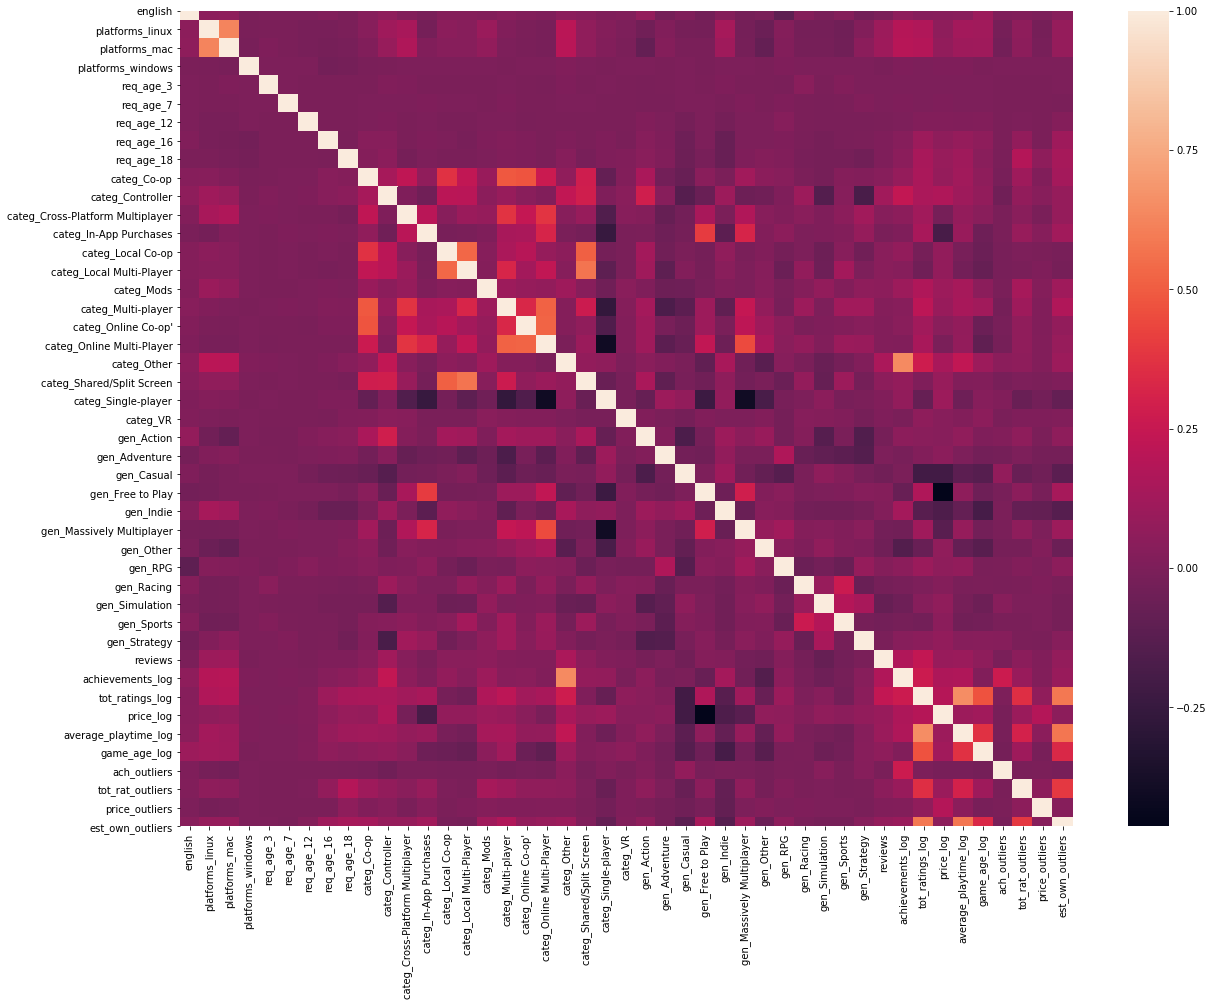

In [118]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr())

In [101]:
dropped_columns = ["positive_ratings_log","median_playtime_log","negative_ratings_log","estim_owners_log","pos_rat_outliers","neg_rat_outliers","avg_playt_outliers"
                  ,"med_playt_outliers","game_age_outliers"]

In [117]:
data = data.drop("game_age_outliers", axis=1)

In [119]:
data = data.drop("name", axis=1)

In [120]:
data.columns

Index(['english', 'platforms_linux', 'platforms_mac', 'platforms_windows',
       'req_age_3', 'req_age_7', 'req_age_12', 'req_age_16', 'req_age_18',
       'categ_Co-op', 'categ_Controller', 'categ_Cross-Platform Multiplayer',
       'categ_In-App Purchases', 'categ_Local Co-op',
       'categ_Local Multi-Player', 'categ_Mods', 'categ_Multi-player',
       'categ_Online Co-op'', 'categ_Online Multi-Player', 'categ_Other',
       'categ_Shared/Split Screen', 'categ_Single-player', 'categ_VR',
       'gen_Action', 'gen_Adventure', 'gen_Casual', 'gen_Free to Play',
       'gen_Indie', 'gen_Massively Multiplayer', 'gen_Other', 'gen_RPG',
       'gen_Racing', 'gen_Simulation', 'gen_Sports', 'gen_Strategy', 'reviews',
       'achievements_log', 'tot_ratings_log', 'price_log',
       'average_playtime_log', 'game_age_log', 'ach_outliers',
       'tot_rat_outliers', 'price_outliers', 'est_own_outliers'],
      dtype='object')

In [121]:
data.shape

(27075, 45)

In [122]:
data_clean = data.copy()

In [123]:
data_clean

,english,platforms_linux,platforms_mac,platforms_windows,req_age_3,req_age_7,req_age_12,req_age_16,req_age_18,categ_Co-op,...,reviews,achievements_log,tot_ratings_log,price_log,average_playtime_log,game_age_log,ach_outliers,tot_rat_outliers,price_outliers,est_own_outliers
0,1,1,1,1,0,0,0,0,0,0,...,1,0.000000,11.758793,2.102914,9.776393,2.944439,0,1,0,1
1,1,1,1,1,0,0,0,0,0,0,...,1,0.000000,8.281724,1.607436,5.627621,3.044522,0,0,0,1
2,1,1,1,1,0,0,0,0,0,0,...,1,0.000000,8.246434,1.607436,5.236442,2.833213,0,0,0,1
3,1,1,1,1,0,0,0,0,0,0,...,1,0.000000,7.339538,1.607436,5.556828,2.890372,0,0,0,1
4,1,1,1,1,0,0,0,0,0,0,...,1,0.000000,8.619389,1.607436,6.437752,2.995732,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1,0,0,1,0,0,0,0,0,0,...,1,2.079442,1.098612,1.128171,0.000000,0.000000,0,0,0,0
27071,1,0,0,1,0,0,0,0,0,0,...,1,0.000000,2.197225,0.989541,0.000000,0.000000,0,0,0,0
27072,1,0,0,1,0,0,0,0,0,1,...,0,3.218876,0.000000,1.607436,0.000000,0.000000,0,0,0,0
27073,1,0,1,1,0,0,0,0,0,0,...,1,0.000000,0.693147,1.822935,0.000000,0.000000,0,0,0,0


In [124]:
data_clean.reviews.value_counts()

1    21923
0     5152
Name: reviews, dtype: int64

## MODELS (1st version with data_clean)

### Train, test, split

In [117]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.drop("reviews", axis=1),
                                                   data_clean.reviews.astype(int),
                                                   test_size=1/3,
                                                   random_state=42,
                                                   stratify=data_clean.reviews.astype(int))

### Logitsic Regression

In [118]:
lr_1 = LogisticRegression()
lr_1.fit(X_train, y_train)

pred_lr_1 = lr_1.predict(X_test)

cm_lr_1 = confusion_matrix(y_test, pred_lr_1)
print(cm_lr_1)
acc_lr_1 = accuracy_score(y_test, pred_lr_1)
print(acc_lr_1)
prec_lr_1 = precision_score(y_test, pred_lr_1)
print(prec_lr_1)
ras_lr_1 = roc_auc_score(y_test, pred_lr_1)
print(ras_lr_1)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 129 1588]
 [ 132 7176]]
0.8094182825484765
0.8188041989958923
0.528534322571637


### NuSVC (Nu Support Vector Machine/Classifier)

In [119]:
nusvm_1 = NuSVC(nu=0.3)
nusvm_1.fit(X_train, y_train)

pred_nusvm_1 = nusvm_1.predict(X_test)

cm_nusvm_1 = confusion_matrix(y_test, pred_nusvm_1)
print(cm_nusvm_1)
acc_nusvm_1 = accuracy_score(y_test, pred_nusvm_1)
print(acc_nusvm_1)
prec_nusvm_1 = precision_score(y_test, pred_nusvm_1)
print(prec_nusvm_1)
ras_nusvm_1 = roc_auc_score(y_test, pred_nusvm_1)
print(ras_nusvm_1)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[ 383 1334]
 [ 611 6697]]
0.7844875346260388
0.8338936620595193
0.5697282383990354


### Random Forest

In [120]:
rf_1 = RandomForestClassifier()
rf_1.fit(X_train, y_train)

pred_rf_1 = rf_1.predict(X_test)

cm_rf_1 = confusion_matrix(y_test, pred_rf_1)
print(cm_rf_1)
acc_rf_1 = accuracy_score(y_test, pred_rf_1)
print(acc_rf_1)
prec_rf_1 = precision_score(y_test, pred_rf_1)
print(prec_rf_1)
ras_rf_1 = roc_auc_score(y_test, pred_rf_1)
print(ras_rf_1)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 459 1258]
 [ 659 6649]]
0.787590027700831
0.8409004679398002
0.5885757910766446


### KNN (KNeighborsClassifier)

In [121]:
knn_1 = KNeighborsClassifier(n_neighbors=19, weights="distance")
knn_1.fit(X_train, y_train)

pred_knn_1 = knn_1.predict(X_test)

cm_knn_1 = confusion_matrix(y_test, pred_knn_1)
print(cm_knn_1)
acc_knn_1 = accuracy_score(y_test, pred_knn_1)
print(acc_knn_1)
prec_knn_1 = precision_score(y_test, pred_knn_1)
print(prec_knn_1)
ras_knn_1 = roc_auc_score(y_test, pred_knn_1)
print(ras_knn_1)

[[ 270 1447]
 [ 260 7048]]
0.8108587257617729
0.829664508534432
0.5608367849245081


### RFE

In [125]:
X = data_clean.drop("reviews", axis=1)
y = data_clean.reviews

In [126]:
estimator = LinearRegression()

In [127]:
selector = RFE(estimator)

In [128]:
selector.fit(X,y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=None, step=1, verbose=0)

In [129]:
rfe_select = list(X.columns[selector.support_])

In [130]:
rfe_select

['english',
 'platforms_linux',
 'platforms_mac',
 'platforms_windows',
 'req_age_3',
 'req_age_12',
 'req_age_16',
 'req_age_18',
 'categ_Controller',
 'categ_In-App Purchases',
 'categ_Local Multi-Player',
 'categ_Shared/Split Screen',
 'gen_Action',
 'gen_Free to Play',
 'gen_Massively Multiplayer',
 'gen_Racing',
 'gen_Simulation',
 'tot_ratings_log',
 'game_age_log',
 'tot_rat_outliers',
 'price_outliers',
 'est_own_outliers']

In [131]:
data_clean2 = data_clean[rfe_select]

In [132]:
data_clean2["reviews"] = data_clean.reviews

C:\Users\jeanb\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [133]:
data_clean2.columns

Index(['english', 'platforms_linux', 'platforms_mac', 'platforms_windows',
       'req_age_3', 'req_age_12', 'req_age_16', 'req_age_18',
       'categ_Controller', 'categ_In-App Purchases',
       'categ_Local Multi-Player', 'categ_Shared/Split Screen', 'gen_Action',
       'gen_Free to Play', 'gen_Massively Multiplayer', 'gen_Racing',
       'gen_Simulation', 'tot_ratings_log', 'game_age_log', 'tot_rat_outliers',
       'price_outliers', 'est_own_outliers', 'reviews'],
      dtype='object')

## MODELS (2nd version with data_clean2, RFE)

### Train, test, split

In [132]:
X_train, X_test, y_train, y_test = train_test_split(data_clean2.drop("reviews", axis=1),
                                                   data_clean2.reviews.astype(int),
                                                   test_size=1/3,
                                                   random_state=42,
                                                   stratify=data_clean2.reviews.astype(int))

### Logitsic Regression

In [133]:
lr_2 = LogisticRegression()
lr_2.fit(X_train, y_train)

pred_lr_2 = lr_2.predict(X_test)

cm_lr_2 = confusion_matrix(y_test, pred_lr_2)
print(cm_lr_2)
acc_lr_2 = accuracy_score(y_test, pred_lr_2)
print(acc_lr_2)
prec_lr_2 = precision_score(y_test, pred_lr_2)
print(prec_lr_2)
ras_lr_2 = roc_auc_score(y_test, pred_lr_2)
print(ras_lr_2)

[[  91 1626]
 [  86 7222]]
0.8103047091412743
0.8162296564195298
0.5206157460138944


C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### NuSVC (Nu Support Vector Machine/Classifier)

In [134]:
nusvm_2 = NuSVC(nu=0.3)
nusvm_2.fit(X_train, y_train)

pred_nusvm_2 = nusvm_2.predict(X_test)

cm_nusvm_2 = confusion_matrix(y_test, pred_nusvm_2)
print(cm_nusvm_2)
acc_nusvm_2 = accuracy_score(y_test, pred_nusvm_2)
print(acc_nusvm_2)
prec_nusvm_2 = precision_score(y_test, pred_nusvm_2)
print(prec_nusvm_2)
ras_nusvm_2 = roc_auc_score(y_test, pred_nusvm_2)
print(ras_nusvm_2)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[ 584 1133]
 [1827 5481]]
0.6720221606648199
0.8286967039612942
0.5450640652300525


### Random Forest

In [135]:
rf_2 = RandomForestClassifier()
rf_2.fit(X_train, y_train)

pred_rf_2 = rf_2.predict(X_test)

cm_rf_2 = confusion_matrix(y_test, pred_rf_2)
print(cm_rf_2)
acc_rf_2 = accuracy_score(y_test, pred_rf_2)
print(acc_rf_2)
prec_rf_2 = precision_score(y_test, pred_rf_2)
print(prec_rf_2)
ras_rf_2 = roc_auc_score(y_test, pred_rf_2)
print(ras_rf_2)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 376 1341]
 [ 717 6591]]
0.7719667590027701
0.8309379727685325
0.5604374730431606


### KNN (KNeighborsClassifier)

In [136]:
knn_2 = KNeighborsClassifier(n_neighbors=19, weights="distance")
knn_2.fit(X_train, y_train)

pred_knn_2 = knn_2.predict(X_test)

cm_knn_2 = confusion_matrix(y_test, pred_knn_2)
print(cm_knn_2)
acc_knn_2 = accuracy_score(y_test, pred_knn_2)
print(acc_knn_2)
prec_knn_2 = precision_score(y_test, pred_knn_2)
print(prec_knn_2)
ras_knn_2 = roc_auc_score(y_test, pred_knn_2)
print(ras_knn_2)

[[ 339 1378]
 [ 584 6724]]
0.7826038781163435
0.8299185386324365
0.5587624830289462


### Scaling

In [134]:
X_to_scale = data_clean2.drop("reviews", axis=1)

In [135]:
scaler = StandardScaler()
scaler.fit(X_to_scale)
data_clean3 = pd.DataFrame(scaler.transform(X_to_scale), columns=X_to_scale.columns)

In [137]:
data_clean3["reviews"] = data_clean2.reviews

In [138]:
data_clean2.head()

,english,platforms_linux,platforms_mac,platforms_windows,req_age_3,req_age_12,req_age_16,req_age_18,categ_Controller,categ_In-App Purchases,...,gen_Free to Play,gen_Massively Multiplayer,gen_Racing,gen_Simulation,tot_ratings_log,game_age_log,tot_rat_outliers,price_outliers,est_own_outliers,reviews
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,11.758793,2.944439,1,0,1,1
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,8.281724,3.044522,0,0,1,1
2,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,8.246434,2.833213,0,0,1,1
3,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,7.339538,2.890372,0,0,1,1
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,8.619389,2.995732,0,0,1,1


In [139]:
data_clean3.head()

,english,platforms_linux,platforms_mac,platforms_windows,req_age_3,req_age_12,req_age_16,req_age_18,categ_Controller,categ_In-App Purchases,...,gen_Free to Play,gen_Massively Multiplayer,gen_Racing,gen_Simulation,tot_ratings_log,game_age_log,tot_rat_outliers,price_outliers,est_own_outliers,reviews
0,0.138696,2.042528,1.535149,0.013591,-0.02016,-0.051995,-0.084511,-0.107269,-0.760069,-0.161713,...,-0.259159,-0.165639,-0.198261,-0.487211,3.625781,3.247646,8.348168,-0.064161,3.251993,1
1,0.138696,2.042528,1.535149,0.013591,-0.02016,-0.051995,-0.084511,-0.107269,-0.760069,-0.161713,...,-0.259159,-0.165639,-0.198261,-0.487211,2.033940,3.401914,-0.119787,-0.064161,3.251993,1
2,0.138696,2.042528,1.535149,0.013591,-0.02016,-0.051995,-0.084511,-0.107269,-0.760069,-0.161713,...,-0.259159,-0.165639,-0.198261,-0.487211,2.017784,3.076204,-0.119787,-0.064161,3.251993,1
3,0.138696,2.042528,1.535149,0.013591,-0.02016,-0.051995,-0.084511,-0.107269,-0.760069,-0.161713,...,-0.259159,-0.165639,-0.198261,-0.487211,1.602597,3.164307,-0.119787,-0.064161,3.251993,1
4,0.138696,2.042528,1.535149,0.013591,-0.02016,-0.051995,-0.084511,-0.107269,-0.760069,-0.161713,...,-0.259159,-0.165639,-0.198261,-0.487211,2.188527,3.326709,-0.119787,-0.064161,3.251993,1


## MODELS (3rd version with data_clean2, RFE and scaling)

### Train, test, split

In [140]:
X_train, X_test, y_train, y_test = train_test_split(data_clean3.drop("reviews", axis=1),
                                                   data_clean3.reviews.astype(int),
                                                   test_size=1/3,
                                                   random_state=42,
                                                   stratify=data_clean3.reviews.astype(int))

### Logitsic Regression

In [141]:
lr_3 = LogisticRegression()
lr_3.fit(X_train, y_train)

pred_lr_3 = lr_3.predict(X_test)

cm_lr_3 = confusion_matrix(y_test, pred_lr_3)
print(cm_lr_3)
acc_lr_3 = accuracy_score(y_test, pred_lr_3)
print(acc_lr_3)
prec_lr_3 = precision_score(y_test, pred_lr_3)
print(prec_lr_3)
ras_lr_3 = roc_auc_score(y_test, pred_lr_3)
print(ras_lr_3)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[  91 1626]
 [  87 7221]]
0.8101939058171745
0.8162088843675822
0.5205473278420278


### NuSVC (Nu Support Vector Machine/Classifier)

In [142]:
nusvm_3 = NuSVC(nu=0.3)
nusvm_3.fit(X_train, y_train)

pred_nusvm_3 = nusvm_3.predict(X_test)

cm_nusvm_3 = confusion_matrix(y_test, pred_nusvm_3)
print(cm_nusvm_3)
acc_nusvm_3 = accuracy_score(y_test, pred_nusvm_3)
print(acc_nusvm_3)
prec_nusvm_3 = precision_score(y_test, pred_nusvm_3)
print(prec_nusvm_3)
ras_nusvm_3 = roc_auc_score(y_test, pred_nusvm_3)
print(ras_nusvm_3)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[ 203 1514]
 [ 506 6802]]
0.7761772853185596
0.817941317941318
0.5244951400384895


### Random Forest

In [143]:
rf_3 = RandomForestClassifier()
rf_3.fit(X_train, y_train)

pred_rf_3 = rf_3.predict(X_test)

cm_rf_3 = confusion_matrix(y_test, pred_rf_3)
print(cm_rf_3)
acc_rf_3 = accuracy_score(y_test, pred_rf_3)
print(acc_rf_3)
prec_rf_3 = precision_score(y_test, pred_rf_3)
print(prec_rf_3)
ras_rf_3 = roc_auc_score(y_test, pred_rf_3)
print(ras_rf_3)

C:\Users\jeanb\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[ 374 1343]
 [ 729 6579]]
0.770415512465374
0.8304721030042919
0.5590340437984684


### KNN (KNeighborsClassifier)

In [144]:
knn_3 = KNeighborsClassifier(n_neighbors=19, weights="distance")
knn_3.fit(X_train, y_train)

pred_knn_3 = knn_3.predict(X_test)

cm_knn_3 = confusion_matrix(y_test, pred_knn_3)
print(cm_knn_3)
acc_knn_3 = accuracy_score(y_test, pred_knn_3)
print(acc_knn_3)
prec_knn_3 = precision_score(y_test, pred_knn_3)
print(prec_knn_3)
ras_knn_3 = roc_auc_score(y_test, pred_knn_3)
print(ras_knn_3)

[[ 327 1390]
 [ 572 6736]]
0.7826038781163435
0.8289441299532365
0.5560890339975754
